## Analysis of geometric parameters in relaxed structures

This notebook provides the functions to save and plot geometric quantities such bond lengths, angles and dihedrals extracted from PDB files, and RMSD computed with respect to the original structures. With small modifications in the main function, it can be used to analyse the trajectories obtained with all the different parameters.

In [1]:
import mdtraj as md
import numpy as np
import sys
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.backends.backend_pdf
from os.path import exists
from os.path import getsize
import math
from cmath import rect, phase
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.style.use('default')
plt.rcParams["font.family"] = "serif"
rc('text.latex', preamble=r'\usepackage{cmbright}')

In [16]:
# computes bond lengths for a given frame in the trajectory, for all the combinations of particles considered, 
# contained in bdict
def compute_bonds_lengths(P,O,C,R4,R1,C1,U1,A1,G1,bdict,last_frame):

    bdict['P-O'].extend(md.compute_distances(last_frame,np.array([P,O[1:]]).transpose()).reshape(-1,).tolist())
    bdict['O-C'].extend(md.compute_distances(last_frame,np.array([O,C]).transpose()).reshape(-1,).tolist())
    bdict['C-R4'].extend(md.compute_distances(last_frame,np.array([C,R4]).transpose()).reshape(-1,).tolist())
    bdict['R4-P'].extend(md.compute_distances(last_frame,np.array([R4[:-1],P]).transpose()).reshape(-1,).tolist())
    bdict['R4-R1'].extend(md.compute_distances(last_frame,np.array([R4,R1]).transpose()).reshape(-1,).tolist())

    if C1.size > 0:
        bdict['R1-C1'].extend(md.compute_distances(last_frame,np.array([C1-1,C1]).transpose()).reshape(-1,).tolist())
    if U1.size > 0:
        bdict['R1-U1'].extend(md.compute_distances(last_frame,np.array([U1-1,U1]).transpose()).reshape(-1,).tolist())
    if A1.size > 0:
        bdict['R1-A1'].extend(md.compute_distances(last_frame,np.array([A1-1,A1]).transpose()).reshape(-1,).tolist())
        bdict['A1-A2'].extend(md.compute_distances(last_frame,np.array([A1,A1+1]).transpose()).reshape(-1,).tolist())
    if G1.size > 0:
        bdict['R1-G1'].extend(md.compute_distances(last_frame,np.array([G1-1,G1]).transpose()).reshape(-1,).tolist())
        bdict['G1-G2'].extend(md.compute_distances(last_frame,np.array([G1,G1+1]).transpose()).reshape(-1,).tolist())

    return


# computes angles for a given frame in the trajectory, for all the combinations of particles considered, 
# contained in adict
def compute_bonds_angles(P,O,C,R4,R1,C1,U1,A1,G1,adict,last_frame):

    adict['P-O-C'].extend(md.compute_angles(last_frame,np.array([P,O[1:],C[1:]]).transpose()).reshape(-1,).tolist())
    adict['O-C-R4'].extend(md.compute_angles(last_frame,np.array([O,C,R4]).transpose()).reshape(-1,).tolist())
    adict['C-R4-P'].extend(md.compute_angles(last_frame,np.array([C[:-1],R4[:-1],P]).transpose()).reshape(-1,).tolist())
    adict['R4-P-O'].extend(md.compute_angles(last_frame,np.array([R4[:-1],P,O[1:]]).transpose()).reshape(-1,).tolist())
    adict['C-R4-R1'].extend(md.compute_angles(last_frame,np.array([C,R4,R1]).transpose()).reshape(-1,).tolist())
    adict['R1-R4-P'].extend(md.compute_angles(last_frame,np.array([R1[:-1],R4[:-1],P]).transpose()).reshape(-1,).tolist())

    if A1.size > 0:
        adict['R4-R1-A1'].extend(md.compute_angles(last_frame,np.array([A1-2,A1-1,A1]).transpose()).reshape(-1,).tolist())
        adict['R1-A1-A2'].extend(md.compute_angles(last_frame,np.array([A1-1,A1,A1+1]).transpose()).reshape(-1,).tolist())
    if U1.size > 0:
        adict['R4-R1-U1'].extend(md.compute_angles(last_frame,np.array([U1-2,U1-1,U1]).transpose()).reshape(-1,).tolist())
    if G1.size > 0:
        adict['R4-R1-G1'].extend(md.compute_angles(last_frame,np.array([G1-2,G1-1,G1]).transpose()).reshape(-1,).tolist())
        adict['R1-G1-G2'].extend(md.compute_angles(last_frame,np.array([G1-1,G1,G1+1]).transpose()).reshape(-1,).tolist())
    if C1.size > 0:
        adict['R4-R1-C1'].extend(md.compute_angles(last_frame,np.array([C1-2,C1-1,C1]).transpose()).reshape(-1,).tolist())

    return


# computes dihedrals for a given frame in the trajectory, for all the combinations of particles considered, 
# contained in bdict
def compute_dihedrals_angles(P,O,C,R4,R1,C1,U1,A1,G1,ddict,last_frame,top):

    ddict['C-R4-P-O'].extend(md.compute_dihedrals(last_frame,np.array([C[:-1],R4[:-1],P,O[1:]]).transpose()).reshape(-1,).tolist())
    ddict['R1-R4-P-O'].extend(md.compute_dihedrals(last_frame,np.array([R1[:-1],R4[:-1],P,O[1:]]).transpose()).reshape(-1,).tolist())
    ddict['O-C-R4-P'].extend(md.compute_dihedrals(last_frame,np.array([O[:-1],C[:-1],R4[:-1],P]).transpose()).reshape(-1,).tolist())
    ddict['O-C-R4-R1'].extend(md.compute_dihedrals(last_frame,np.array([O,C,R4,R1]).transpose()).reshape(-1,).tolist())
    ddict['P-O-C-R4'].extend(md.compute_dihedrals(last_frame,np.array([P,O[1:],C[1:],R4[1:]]).transpose()).reshape(-1,).tolist())
    ddict['R4-P-O-C'].extend(md.compute_dihedrals(last_frame,np.array([R4[:-1],P,O[1:],C[1:]]).transpose()).reshape(-1,).tolist())

    if A1.size > 0:
        ddict['R4-R1-A1-A2'].extend(md.compute_dihedrals(last_frame,np.array([A1-2,A1-1,A1,A1+1]).transpose()).reshape(-1,).tolist())
        ddict['R4-A1-A2-R1'].extend(md.compute_dihedrals(last_frame,np.array([A1-2,A1,A1+1,A1-1]).transpose()).reshape(-1,).tolist())
        ddict['C-R4-R1-A1'].extend(md.compute_dihedrals(last_frame,np.array([A1-3,A1-2,A1-1,A1]).transpose()).reshape(-1,).tolist())
        if A1[-1]+2 > top.n_atoms:
            ddict['P-R4-R1-A1'].extend(md.compute_dihedrals(last_frame,np.array([A1+2,A1-2,A1-1,A1]).transpose()).reshape(-1,).tolist())  # check it is not the last residue
        else:
            if A1.size > 1:
                ddict['P-R4-R1-A1'].extend(md.compute_dihedrals(last_frame,np.array([A1[:-1]+2,A1[:-1]-2,A1[:-1]-1,A1[:-1]]).transpose()).reshape(-1,).tolist())
    if U1.size > 0:
        ddict['C-R4-R1-U1'].extend(md.compute_dihedrals(last_frame,np.array([U1-3,U1-2,U1-1,U1]).transpose()).reshape(-1,).tolist())
        if U1[-1]+1 > top.n_atoms:
            ddict['P-R4-R1-U1'].extend(md.compute_dihedrals(last_frame,np.array([U1+2,U1-2,U1-1,U1]).transpose()).reshape(-1,).tolist())  # check it is not the last residue
        else:
            if U1.size > 1:
                ddict['P-R4-R1-U1'].extend(md.compute_dihedrals(last_frame,np.array([U1[:-1]+2,U1[:-1]-2,U1[:-1]-1,U1[:-1]]).transpose()).reshape(-1,).tolist())
    if G1.size > 0:
        ddict['R4-R1-G1-G2'].extend(md.compute_dihedrals(last_frame,np.array([G1-2,G1-1,G1,G1+1]).transpose()).reshape(-1,).tolist())
        ddict['R4-G1-G2-R1'].extend(md.compute_dihedrals(last_frame,np.array([G1-2,G1,G1+1,G1-1]).transpose()).reshape(-1,).tolist())
        ddict['C-R4-R1-G1'].extend(md.compute_dihedrals(last_frame,np.array([G1-3,G1-2,G1-1,G1]).transpose()).reshape(-1,).tolist())
        if G1[-1]+2 > top.n_atoms:
            ddict['P-R4-R1-G1'].extend(md.compute_dihedrals(last_frame,np.array([G1+2,G1-2,G1-1,G1]).transpose()).reshape(-1,).tolist())  # check it is not the last residue
        else:
            if G1.size > 1:
                ddict['P-R4-R1-G1'].extend(md.compute_dihedrals(last_frame,np.array([G1[:-1]+2,G1[:-1]-2,G1[:-1]-1,G1[:-1]]).transpose()).reshape(-1,).tolist())
    if C1.size > 0:
        ddict['C-R4-R1-C1'].extend(md.compute_dihedrals(last_frame,np.array([C1-3,C1-2,C1-1,C1]).transpose()).reshape(-1,).tolist())
        if C1[-1]+1 > top.n_atoms:
            ddict['P-R4-R1-C1'].extend(md.compute_dihedrals(last_frame,np.array([C1+2,C1-2,C1-1,C1]).transpose()).reshape(-1,).tolist())  # check it is not the last residue
        else:
            if C1.size > 1:
                ddict['P-R4-R1-C1'].extend(md.compute_dihedrals(last_frame,np.array([C1[:-1]+2,C1[:-1]-2,C1[:-1]-1,C1[:-1]]).transpose()).reshape(-1,).tolist())

    return

In [17]:
def main():

    # Dictionaries definitions
    bond_pairs = ['R4-P','R4-R1','R1-G1','R1-A1','R1-U1','R1-C1','G1-G2','A1-A2','C-R4','P-O','O-C']
    bdict = {key: [] for key in bond_pairs}

    angle_triplets = ['R4-R1-A1','R4-R1-U1','R4-R1-G1','R4-R1-C1','R1-A1-A2','R1-G1-G2','P-O-C',
    'O-C-R4','C-R4-P','R4-P-O','C-R4-R1','R1-R4-P']
    adict = {key: [] for key in angle_triplets}

    dihedrals_quadruplets = ['R4-R1-G1-G2','R4-R1-A1-A2','R4-A1-A2-R1','R4-G1-G2-R1','C-R4-R1-A1',
    'C-R4-R1-G1','C-R4-R1-C1','C-R4-R1-U1','P-R4-R1-A1','P-R4-R1-G1','P-R4-R1-C1','P-R4-R1-U1',
    'C-R4-P-O','R1-R4-P-O','O-C-R4-P','O-C-R4-R1','P-O-C-R4','R4-P-O-C']
    ddict = {key: [] for key in dihedrals_quadruplets}
    
    rmsd = []

    # Execution
    with open('relaxation_names.txt','r') as f:
        file_list = f.read().splitlines()

    for i,file in enumerate(file_list):
        
        # check if all files exist
        file_amber = file.split('_',maxsplit=1)[1]     # sequence name, without 'relaxed_' prefix
        print(file+",    %i/%i" %(i+1,len(file_list)))
    
        if not exists('Amber/Minimized/'+file_amber+'.pdb'):
            continue

        if not exists('Amber/Minimized/'+file_amber+'.pdb'):   # for relaxation with other parameters, change folder
            continue
        
        # load initial configuration, last configuration and topology (necessary to parse by atom names)
        ref = md.load('Amber/Minimized/'+file_amber+'.pdb')
        last_frame = md.load_frame('Amber/Minimized/'+file_amber+'.pdb',-1)
        top = last_frame.topology
        
        # compute rmsd between last and initial configuration
        rmsd_tmp = md.rmsd(last_frame,ref) 
        rmsd.append(rmsd_tmp)

        P = top.select("name == P")
        if len(P) < 6:
            continue

        O = top.select("symbol == O")  # all sequences start from oxygen, doesn't read name == O5*
        C = O+1                        # doesn't read name == C5* nor symbol == C
        R4 = top.select("name == CA")
        R1 = top.select("name == CY")
        C1 = top.select("name == C1")
        U1 = top.select("name == U1")
        A1 = top.select("name == A1")
        G1 = top.select("name == G1")
        
        # compute bond lengths, angles and dihedrals for 
        compute_bonds_lengths(P,O,C,R4,R1,C1,U1,A1,G1,bdict,last_frame)
        compute_bonds_angles(P,O,C,R4,R1,C1,U1,A1,G1,adict,last_frame)
        compute_dihedrals_angles(P,O,C,R4,R1,C1,U1,A1,G1,ddict,last_frame,top)
    
    # save dictionaries for geometrical quantities and rmsd in correct folder
    with open('Amber/bonds.pkl', 'wb') as f: pickle.dump(bdict, f)
    with open('Amber/angles.pkl', 'wb') as f: pickle.dump(adict, f)
    with open('Amber/dihedrals.pkl', 'wb') as f: pickle.dump(ddict, f)
        
    rmsd = np.array(rmsd)
    np.save('Amber/rmsd.npy',rmsd)

    return bdict, adict, ddict

In [18]:
# If dictionaries for bonds, angles and torsions already obtained, skip this cell

main()

relaxation_1ato_c1,    1/1225
relaxation_1ato_c2,    2/1225
relaxation_1ato_c3,    3/1225
relaxation_1ato_c4,    4/1225
relaxation_1ato_c5,    5/1225
relaxation_1ato_c6,    6/1225
relaxation_1atv_c1,    7/1225
relaxation_1atv_c2,    8/1225
relaxation_1atv_c3,    9/1225
relaxation_1atv_c4,    10/1225
relaxation_1atv_c5,    11/1225
relaxation_1atw_c1,    12/1225
relaxation_1atw_c2,    13/1225
relaxation_1atw_c3,    14/1225
relaxation_1atw_c4,    15/1225
relaxation_1atw_c5,    16/1225
relaxation_1b36_c10,    17/1225
relaxation_1b36_c11,    18/1225
relaxation_1b36_c12,    19/1225
relaxation_1b36_c1,    20/1225
relaxation_1b36_c2,    21/1225
relaxation_1b36_c3,    22/1225
relaxation_1b36_c4,    23/1225
relaxation_1b36_c5,    24/1225
relaxation_1b36_c6,    25/1225
relaxation_1b36_c7,    26/1225
relaxation_1b36_c8,    27/1225
relaxation_1b36_c9,    28/1225
relaxation_1bgz_c1,    29/1225
relaxation_1bgz_c2,    30/1225
relaxation_1bgz_c3,    31/1225
relaxation_1bgz_c4,    32/1225
relaxation_1bg

({'R4-P': [0.3931000828742981,
   0.3886655569076538,
   0.3877739906311035,
   0.3891432583332062,
   0.4000488817691803,
   0.3962596654891968,
   0.3881271183490753,
   0.39847487211227417,
   0.3919859826564789,
   0.384123295545578,
   0.3865490257740021,
   0.3905121386051178,
   0.3928470015525818,
   0.39662694931030273,
   0.3985328674316406,
   0.3981134295463562,
   0.3890131711959839,
   0.3867725729942322,
   0.3928470015525818,
   0.39662694931030273,
   0.3985328674316406,
   0.3981134295463562,
   0.3890131711959839,
   0.3867725729942322,
   0.3991158902645111,
   0.39595040678977966,
   0.3898369371891022,
   0.38877952098846436,
   0.3941413462162018,
   0.3952997028827667,
   0.3898855745792389,
   0.392198771238327,
   0.3955238163471222,
   0.39571112394332886,
   0.3977092504501343,
   0.3958509564399719,
   0.3962699770927429,
   0.3954210579395294,
   0.3941935896873474,
   0.3849021792411804,
   0.381240576505661,
   0.3959784507751465,
   0.39377522468566895,

In [13]:
# functions to generate subplots with the correct dimensions

def choose_subplot_dimensions(k):
    if k < 5:
        return k, 1
    elif k < 11:
        return math.ceil(k/3), 4
    else:
        # I've chosen to have a maximum of 3 columns
        return math.ceil(k/4), 4


def generate_subplots(k, row_wise=False):
    nrow, ncol = choose_subplot_dimensions(k)
    # Choose your share X and share Y parameters as you wish:
    figure, axes = plt.subplots(nrow, ncol,
                                sharex=False,
                                sharey=False,
                                figsize=(17,17))  # (17,17) for dihedrals, (17,10) for angles and bonds

    # Check if it's an array. If there's only one plot, it's just an Axes obj
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise
        axes = axes.flatten(order=('C' if row_wise else 'F'))

        # Delete any unused axes from the figure, so that they don't show
        # blank x- and y-axis lines
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)

            # Turn ticks on for the last ax in each column, wherever it lands
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1
            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return figure, axes

In [4]:
## Bonds plot

bonds_true = pickle.load(open('Amber/bonds.pkl','rb'))
bonds_free = pickle.load(open('FreeMin/bonds.pkl','rb'))
bonds_old = pickle.load(open('HiRE_old/bonds.pkl','rb'))
bonds_psgd = pickle.load(open('PSGD/bonds.pkl','rb'))
bonds_nogeom = pickle.load(open('NoGeom/bonds.pkl','rb'))
bonds_tanh = pickle.load(open('Tanh/bonds.pkl','rb'))
bonds_dof = pickle.load(open('Less_dof/bonds.pkl','rb'))

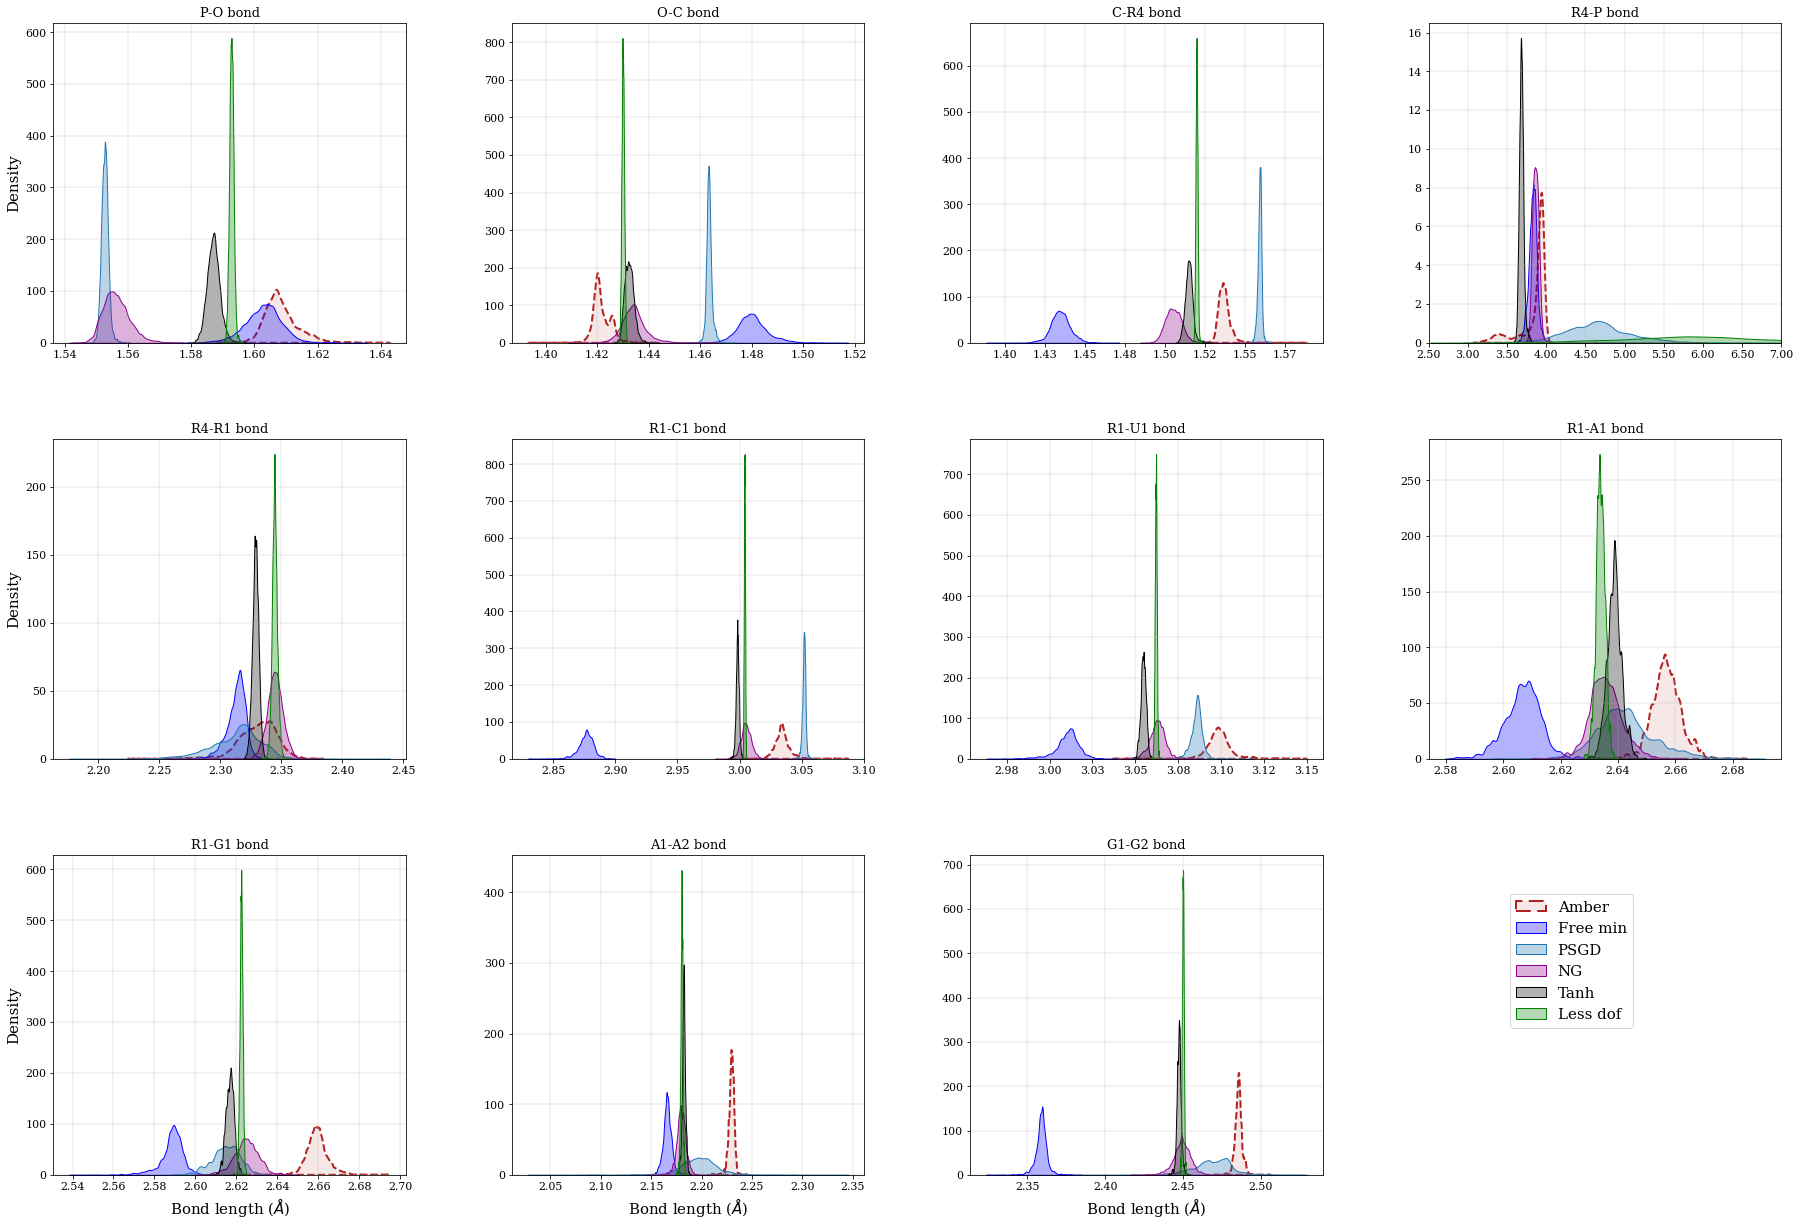

In [9]:
kde_kws = {'shade': True, 'alpha':0.3, 'linewidth': 1, 'bw':0.1}

figure, axes = generate_subplots(len(bonds_true), row_wise=True)
for i, key in enumerate(bonds_true):
    sns.distplot(ax = axes[i], x=np.array(bonds_true[key])*10, hist = False, kde = True,
        kde_kws = {'shade': True, 'alpha':0.1, 'linewidth': 2, 'bw':0.1, 'linestyle':'--'},
                 label='Amber', color='firebrick')
    # sns.distplot(ax = axes[i], x=bonds_old[key], hist = False, kde = True,
    #    kde_kws = kde_kws, label='HiRE old', color='y')
    sns.distplot(ax = axes[i], x=np.array(bonds_free[key])*10, hist = False, kde = True,
        kde_kws = kde_kws, label='Free min', color='b')
    sns.distplot(ax = axes[i], x=np.array(bonds_psgd[key])*10, hist = False, kde = True,
        kde_kws = kde_kws, label='PSGD') #, color='olivedrab')
    sns.distplot(ax = axes[i], x=np.array(bonds_nogeom[key])*10, hist = False, kde = True,
        kde_kws = kde_kws, label='NG' , color='darkmagenta')
    sns.distplot(ax = axes[i], x=np.array(bonds_tanh[key])*10, hist = False, kde = True,
        kde_kws = kde_kws, label='Tanh', color='black')
    sns.distplot(ax = axes[i], x=np.array(bonds_dof[key])*10, hist = False, kde = True,
        kde_kws = kde_kws, label='Less dof', color='green')
    axes[i].set_title(key+' bond', fontsize=13)
    axes[i].set_ylabel('')
    axes[i].grid(linewidth=0.3)
    # axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # axes[i].yaxis.set_major_formatter(NullFormatter())
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    # axes[i].tick_params(axis='y', which='major', left=False, right=False)
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[10].legend(bbox_to_anchor=(1.9,0.9),fontsize=15)
axes[3].set_xlim(2.5,7)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
axes[8].set_xlabel(r'Bond length ($\AA$)',fontsize=15)
axes[9].set_xlabel(r'Bond length ($\AA$)',fontsize=15)
axes[10].set_xlabel(r'Bond length ($\AA$)',fontsize=15)

axes[0].set_ylabel('Density',fontsize=15)
axes[4].set_ylabel('Density',fontsize=15)
axes[8].set_ylabel('Density',fontsize=15)

plt.savefig('bond_distribution.png',bbox_inches='tight',dpi=100)

(5, 11)


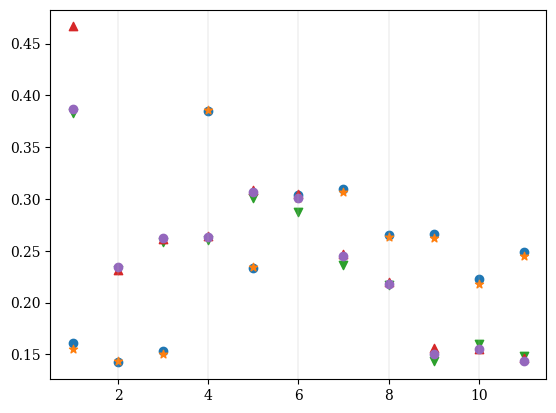

In [24]:
# Variation in mean values

true_mean = [np.array(bonds_true[key]).mean() for key in bonds_true]
free_mean = [np.array(bonds_free[key]).mean() for key in bonds_free]
old_mean = [np.array(bonds_old[key]).mean() for key in bonds_old]
psgd_mean = [np.array(bonds_psgd[key]).mean() for key in bonds_psgd]
nogeom_mean = [np.array(bonds_nogeom[key]).mean() for key in bonds_nogeom]

bond_mean = np.array([true_mean,old_mean,free_mean,psgd_mean,nogeom_mean])
print(bond_mean.shape)

x = np.arange(1,12)
plt.scatter(x,bond_mean[0],marker = 'o')
plt.scatter(x,bond_mean[1],marker = '*')
plt.scatter(x,bond_mean[2], marker = 'v')
plt.scatter(x,bond_mean[3], marker = '^')
plt.scatter(x,bond_mean[4])
plt.grid(axis='x',linewidth=0.2)

In [2]:
## Angles

angles_true = pickle.load(open('Amber/angles.pkl','rb'))
angles_free = pickle.load(open('FreeMin/angles.pkl','rb'))
angles_old = pickle.load(open('HiRE_old/angles.pkl','rb'))
angles_psgd = pickle.load(open('PSGD/angles.pkl','rb'))
angles_nogeom = pickle.load(open('NoGeom/angles.pkl','rb'))
angles_tanh = pickle.load(open('Tanh/angles.pkl','rb'))
angles_dof = pickle.load(open('Less_dof/angles.pkl','rb'))


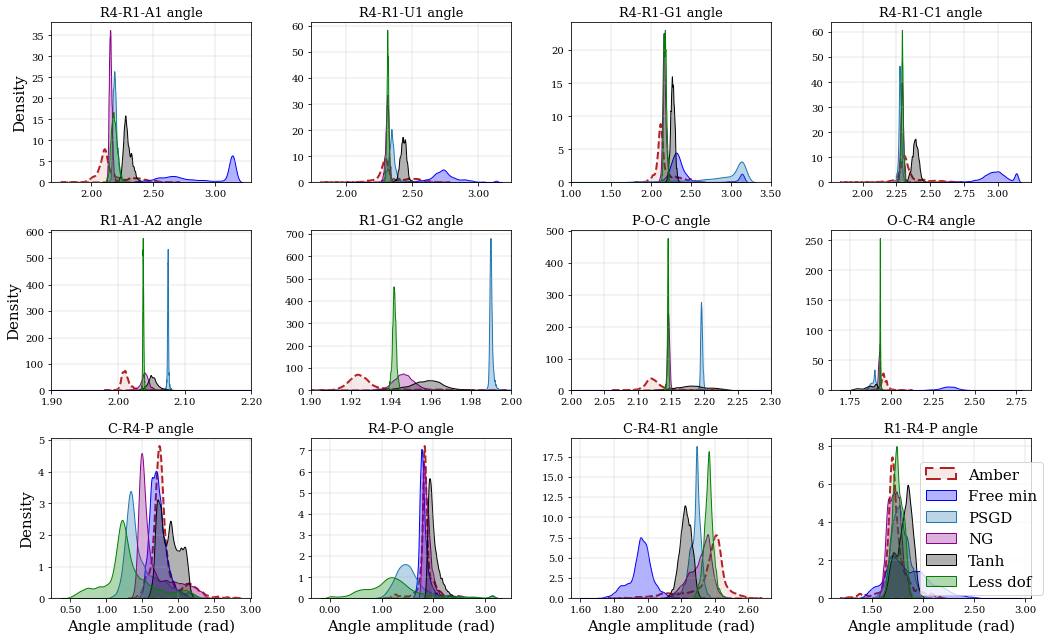

In [8]:
kde_kws = {'shade': True, 'alpha':0.3, 'linewidth': 1, 'bw':0.1}

figure, axes = generate_subplots(len(angles_true), row_wise=True)
for i, key in enumerate(angles_true):
    sns.distplot(ax = axes[i], x=angles_true[key], hist = False, kde = True,
        kde_kws = {'shade': True, 'alpha':0.1, 'linewidth': 2, 'bw':0.1, 'linestyle':'--'},
                 label='Amber', color='firebrick')
    # sns.distplot(ax = axes[i], x=angles_old[key], hist = False, kde = True,
    #     kde_kws = {'shade': True, 'linewidth': 1, 'bw':0.1}, label='HiRE old')
    sns.distplot(ax = axes[i], x=angles_free[key], hist = False, kde = True,
        kde_kws = kde_kws, label='Free min', color='b')
    sns.distplot(ax = axes[i], x=angles_psgd[key], hist = False, kde = True,
        kde_kws = kde_kws, label='PSGD')
    sns.distplot(ax = axes[i], x=angles_nogeom[key], hist = False, kde = True,
        kde_kws = kde_kws, label='NG', color='darkmagenta')
    sns.distplot(ax = axes[i], x=angles_tanh[key], hist = False, kde = True,
        kde_kws = kde_kws, label='Tanh', color='black')
    sns.distplot(ax = axes[i], x=angles_dof[key], hist = False, kde = True,
        kde_kws = kde_kws, label='Less dof', color='green')
    axes[i].set_title(key+' angle', fontsize=13)
    axes[i].set_ylabel('')
    axes[i].grid(linewidth=0.3)
    # axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[11].legend(bbox_to_anchor=(1.1,0.9),fontsize=15)
axes[2].set_xlim([1,3.5])
axes[4].set_xlim([1.9,2.2])
axes[5].set_xlim([1.9,2])
axes[6].set_xlim([2,2.3])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)

axes[8].set_xlabel('Angle amplitude (rad)',fontsize=15)
axes[9].set_xlabel('Angle amplitude (rad)',fontsize=15)
axes[10].set_xlabel('Angle amplitude (rad)',fontsize=15)
axes[11].set_xlabel('Angle amplitude (rad)',fontsize=15)

axes[0].set_ylabel('Density',fontsize=15)
axes[4].set_ylabel('Density',fontsize=15)
axes[8].set_ylabel('Density',fontsize=15)

plt.savefig('angles_distribution.png',bbox_inches='tight',dpi=100)

In [19]:
## Torsions

dihedrals_true = pickle.load(open('Amber/dihedrals.pkl','rb'))
dihedrals_free = pickle.load(open('FreeMin/dihedrals.pkl','rb'))
dihedrals_old = pickle.load(open('HiRE_old/dihedrals.pkl','rb'))
dihedrals_psgd = pickle.load(open('PSGD/dihedrals.pkl','rb'))
dihedrals_nogeom = pickle.load(open('NoGeom/dihedrals.pkl','rb'))
dihedrals_tanh = pickle.load(open('Tanh/dihedrals.pkl','rb'))
dihedrals_dof = pickle.load(open('Less_dof/dihedrals.pkl','rb'))


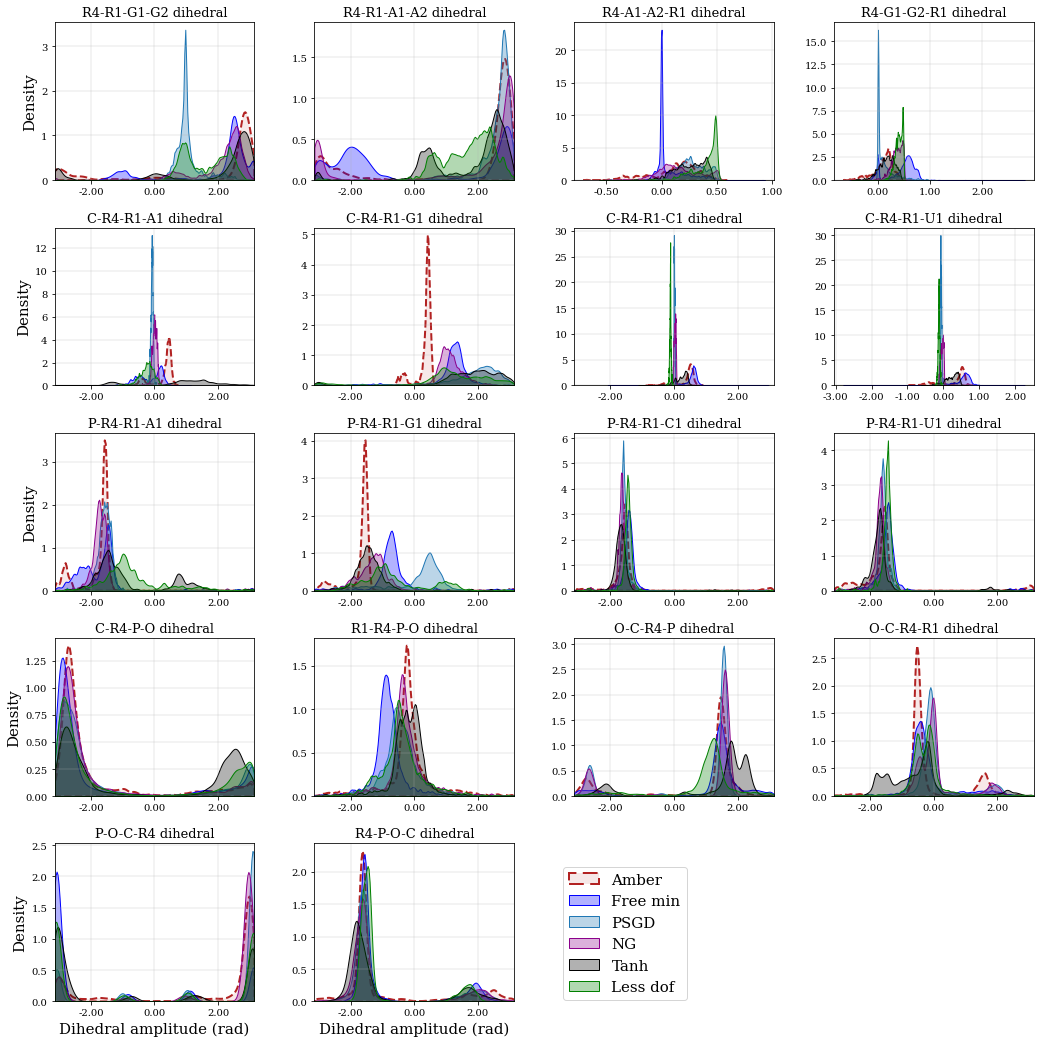

In [20]:
kde_kws = {'shade': True, 'alpha':0.3, 'linewidth': 1, 'clip': (-math.pi, math.pi), 'bw':0.05}

figure, axes = generate_subplots(len(dihedrals_true), row_wise=True)
for i, key in enumerate(dihedrals_true):
    sns.distplot(ax = axes[i], x=dihedrals_true[key], hist=False, kde=True,
        kde_kws = {'shade': True, 'alpha':0.1, 'linewidth': 2, 'clip': (-math.pi, math.pi),
                   'bw':0.05, 'linestyle':'--'}, label='Amber', color='firebrick')
    # sns.distplot(ax = axes[i], x=dihedrals_old[key], hist = False, kde = True,
    #     kde_kws = {'shade': True, 'linewidth': 1, 'clip': (-math.pi, math.pi), 'bw':0.05}, label='HiRE old')
    sns.distplot(ax = axes[i], x=dihedrals_free[key], hist = False, kde = True,
        kde_kws = kde_kws, label='Free min', color='b')
    sns.distplot(ax = axes[i], x=dihedrals_psgd[key], hist = False, kde = True,
        kde_kws = kde_kws, label='PSGD')
    sns.distplot(ax = axes[i], x=dihedrals_nogeom[key], hist = False, kde = True,
        kde_kws = kde_kws, label='NG', color='darkmagenta')
    sns.distplot(ax = axes[i], x=dihedrals_tanh[key], hist = False, kde = True,
        kde_kws = kde_kws, label='Tanh', color='black')
    sns.distplot(ax = axes[i], x=dihedrals_dof[key], hist = False, kde = True,
        kde_kws = kde_kws, label='Less dof', color='green')
    axes[i].set_title(key+' dihedral', fontsize=13)
    axes[i].set_ylabel('')
    axes[i].grid(linewidth=0.3)
    # axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    xlim_old = axes[i].get_xlim()
    if xlim_old[0] < -math.pi or xlim_old[1] > math.pi:
        axes[i].set_xlim([-math.pi,math.pi])
axes[17].legend(bbox_to_anchor=(1.9,0.9),fontsize=15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)

axes[16].set_xlabel('Dihedral amplitude (rad)',fontsize=15)
axes[17].set_xlabel('Dihedral amplitude (rad)',fontsize=15)

axes[0].set_ylabel('Density',fontsize=15)
axes[4].set_ylabel('Density',fontsize=15)
axes[8].set_ylabel('Density',fontsize=15)
axes[12].set_ylabel('Density',fontsize=15)
axes[16].set_ylabel('Density',fontsize=15)

plt.savefig('dihedrals_distribution.png',bbox_inches='tight',dpi=100)